<a href="https://colab.research.google.com/github/yildizyakup/plant-disease-detection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plant Disease Detection

In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from math import exp, sqrt
import glob
import imutils

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
train_images = [cv.imread(file,0) for file in glob.glob("/content/drive/MyDrive/Plant_Disease_Detection/Train/*.pgm")]
test_images =  [cv.imread(file,0) for file in glob.glob("/content/drive/MyDrive/Plant_Disease_Detection/Test/*.pgm")]

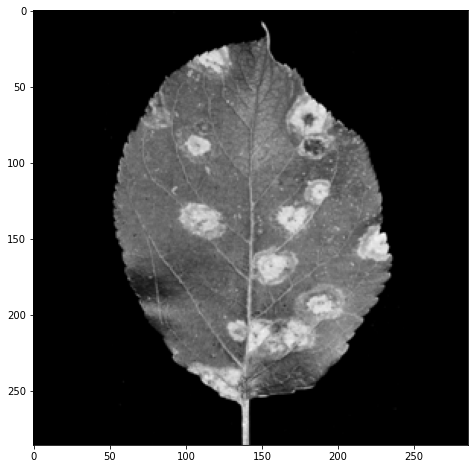

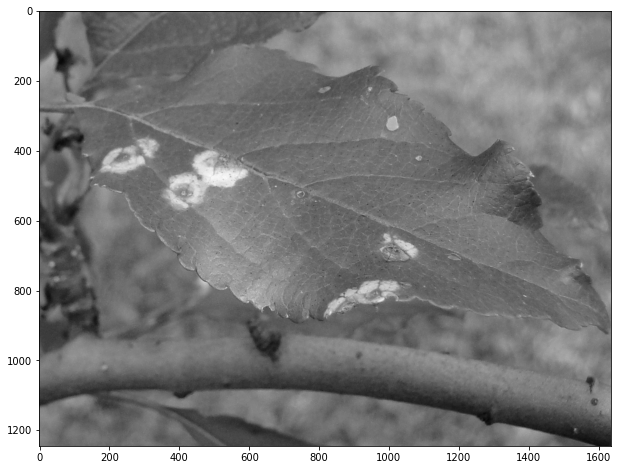

In [5]:
plt.figure(figsize = (13,8))    
plt.imshow(train_images[1],cmap = 'gray')
plt.show()

plt.figure(figsize = (13,8))    
plt.imshow(test_images[0],cmap = 'gray')
plt.show()

Detect when an image is Blurry:
https://www.youtube.com/watch?v=5YP7OoMhXbM

In [6]:
for i in range(len(train_images)):

    laplacian_var = cv.Laplacian(train_images[i],cv.CV_64F).var()
    print("Train image",i+1,":",laplacian_var)
    
    if laplacian_var < 5:
        print("Image is blurry")

Train image 1 : 1168.4074999982643
Train image 2 : 402.19566896145375
Train image 3 : 99.94311960931559
Train image 4 : 1066.6449350548799


In [7]:
for i in range(len(train_images)):

  if np.mean(train_images[i]) > 127:  # The range for a pixel's value in grayscale is (0-255), 127 lies midway
    print("Train image ", i+1, "is bright") # (127 - 255) denotes light image
  else:
    print("Train image ", i+1, "is dark") # denotes dark image

Train image  1 is bright
Train image  2 is dark
Train image  3 is dark
Train image  4 is dark


In [8]:
def remove_lines(image):
    # Create diagonal kernel
  kernel_1 = np.array([[0, 0, 1],
                      [0, 1, 0],
                      [1, 0, 0]], dtype=np.uint8)
  
  kernel_2 = np.array([[0, 1, 0],
                      [0, 1, 0],
                      [0, 1, 0]], dtype=np.uint8)
 
  kernel_3 = np.array([[1, 0, 0],
                      [0, 1, 0],
                      [0, 0, 1]], dtype=np.uint8)
  
  kernel_4 = np.array([[0, 0, 0],
                      [1, 1, 1],
                      [0, 0, 0]], dtype=np.uint8)
  
  kernel = [kernel_1,kernel_2,kernel_3,kernel_4]
  for i in range (len(kernel)):
    image = cv.morphologyEx(image, cv.MORPH_OPEN, kernel[i], iterations=2)

  return image
  

HomomorphicFilter: https://github.com/glasgio/homomorphic-filter

In [9]:
import logging

# Homomorphic filter class
class HomomorphicFilter:
    """Homomorphic filter implemented with diferents filters and an option to an external filter.
    
    High-frequency filters implemented:
        butterworth
        gaussian
    Attributes:
        a, b: Floats used on emphasis filter:
            H = a + b*H
        
        .
    """
    
    def __init__(self, a = 0.5, b = 1.5):
        self.a = float(a)
        self.b = float(b)

    # Filters
    def __butterworth_filter(self, I_shape, filter_params):
        P = I_shape[0]/2
        Q = I_shape[1]/2
        U, V = np.meshgrid(range(I_shape[0]), range(I_shape[1]), sparse=False, indexing='ij')
        Duv = (((U-P)**2+(V-Q)**2)).astype(float)
        H = 1/(1+(Duv/filter_params[0]**2)**filter_params[1])
        return (1 - H)

    def __gaussian_filter(self, I_shape, filter_params):
        P = I_shape[0]/2
        Q = I_shape[1]/2
        H = np.zeros(I_shape)
        U, V = np.meshgrid(range(I_shape[0]), range(I_shape[1]), sparse=False, indexing='ij')
        Duv = (((U-P)**2+(V-Q)**2)).astype(float)
        H = np.exp((-Duv/(2*(filter_params[0])**2)))
        return (1 - H)

    # Methods
    def __apply_filter(self, I, H):
        H = np.fft.fftshift(H)
        I_filtered = (self.a + self.b*H)*I
        return I_filtered

    def filter(self, I, filter_params, filter='butterworth', H = None):
        
        """
        Method to apply homormophic filter on an image
        Attributes:
            I: Single channel image
            filter_params: Parameters to be used on filters:
                butterworth:
                    filter_params[0]: Cutoff frequency 
                    filter_params[1]: Order of filter
                gaussian:
                    filter_params[0]: Cutoff frequency
            filter: Choose of the filter, options:
                butterworth
                gaussian
                external
            H: Used to pass external filter
        """

        #  Validating image
        if len(I.shape) != 2:
            print(I.shape)
            raise Exception('Improper image')

        # Take the image to log domain and then to frequency domain 
        I_log = np.log1p(np.array(I, dtype="float"))
        I_fft = np.fft.fft2(I_log)

        # Filters
        if filter=='butterworth':
            H = self.__butterworth_filter(I_shape = I_fft.shape, filter_params = filter_params)
        elif filter=='gaussian':
            H = self.__gaussian_filter(I_shape = I_fft.shape, filter_params = filter_params)
        elif filter=='external':
            print('external')
            if len(H.shape) != 2:
                raise Exception('Invalid external filter')
        else:
            raise Exception('Selected filter not implemented')
        
        # Apply filter on frequency domain then take the image back to spatial domain
        I_fft_filt = self.__apply_filter(I = I_fft, H = H)
        I_filt = np.fft.ifft2(I_fft_filt)
        I = np.exp(np.real(I_filt))-1
        return np.uint8(I)
# End of class HomomorphicFilter

In [10]:
def setLabelRec(im, point, label):
 connectivity = [[-1, -1], [-1, 0], [-1, +1],
                 [0, -1], [0, +1],
                 [1, -1], [1, 0], [1, +1]] 
 shape = im.shape 
 """ Recursive utility function for CCA """
 im[point[0]][point[1]] = label
 # bu pikseli etiketle
 for offset in connectivity:
     # etraftaki pikseller icin
     y = point[0] + offset[0] # y noktasi
     x = point[1] + offset[1] # x noktasi
     if y < 0 or y >= shape[0] or x < 0 or x >= shape[1]:
         continue # eger goruntunun disina tasildiysa, atla
     if im[y][x] == 255: # eger cevredeki piksel beyaz ise etiketle
         setLabelRec(im, (y, x), label) # recursive cagri label_counter = 0 # etiket sayaci
 white = np.argwhere(im == 255) 
 # goruntudeki beyaz olan yerlerin koordinatlarini al
 label_counter = 0 # etiket sayaci
 while len(white) > 0:
  # eger beyaz bir nokta varsa
  setLabelRec(im, white[0], label_counter) 
  # beyaz noktayi etiketle, recursive bicimde
  white = np.argwhere(im == 255) # beyaz nokta listesini guncelle
  label_counter += 1 # etiket sayacini arttir return im
 

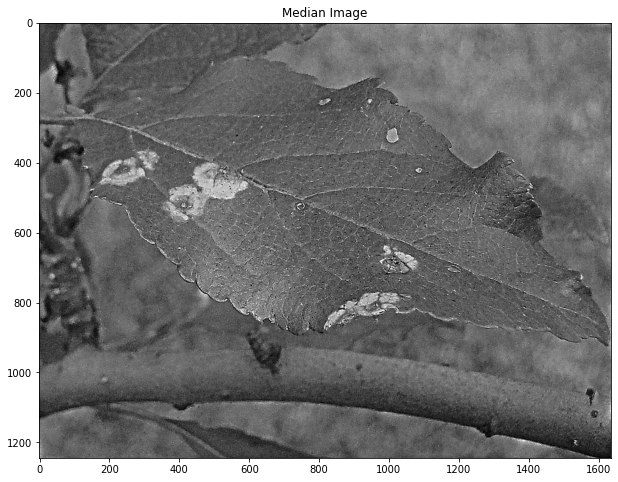

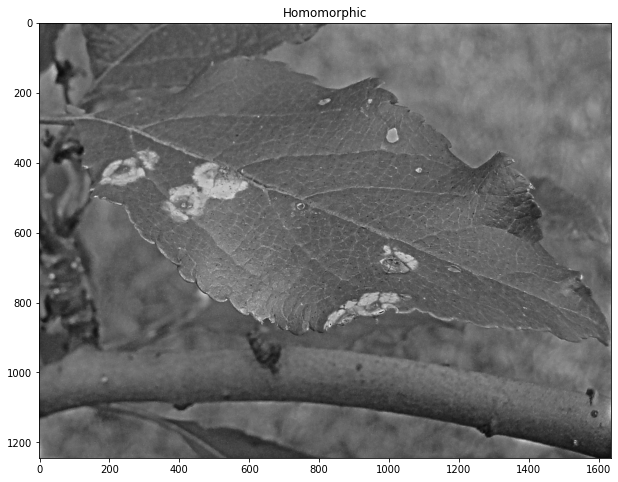

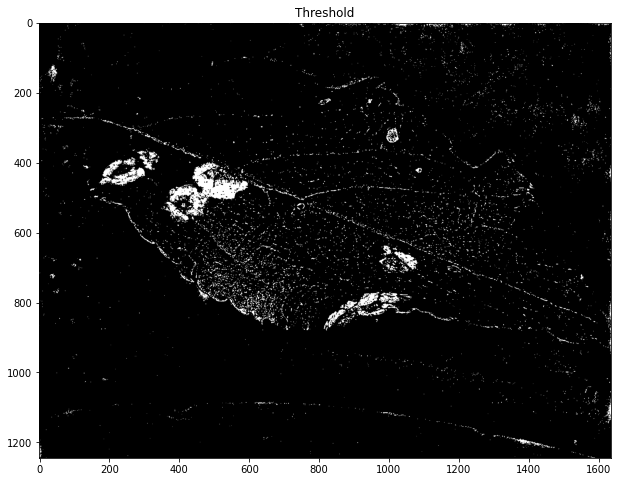

NameError: ignored

In [11]:
#image_copy = train_images[0].copy()
image_copy = test_images[0].copy()

laplacian_var = cv.Laplacian(image_copy,cv.CV_64F).var()
homo_filter = HomomorphicFilter(a = 0.9615, b = 1)
homo_filtered = homo_filter.filter(I=image_copy, filter_params=[30,2])

if laplacian_var < 500:
  kernel = np.array([[-1,-1, -1], 
                    [-1, 9, -1],
                    [-1,-1, -1]])
else:
  kernel = np.array([[0,-1, 0], 
                    [-1,5,-1],
                    [0,-1, 0]])
  
sharpened = cv.filter2D(homo_filtered, -1, kernel)
median = cv.medianBlur(sharpened,3)

plt.figure(figsize = (13,8))   
plt.title("Median Image")
plt.imshow(median,cmap = 'gray')
plt.show()

#_,th = cv.threshold(median,0,255,cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
_,th = cv.threshold(median,154,255,cv.THRESH_BINARY)
#th = cv.adaptiveThreshold(blur, 255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 21,10)

plt.figure(figsize = (13,8))   
plt.title("Homomorphic")
plt.imshow(homo_filtered,cmap = 'gray')
plt.show()

plt.figure(figsize = (13,8))   
plt.title("Threshold")
plt.imshow(th,cmap = 'gray')
plt.show()

kernel3x3 = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
kernel5x5 = cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
kernel13x13 = cv.getStructuringElement(cv.MORPH_ELLIPSE,(13,13))

erosion = cv.erode(th,kernel3x3, iterations = 1)
dilation = cv.dilate(th,kernel3x3,iterations = 1)
opening = cv.morphologyEx(th, cv.MORPH_OPEN, kernel3x3)
closing = cv.morphologyEx(opening, cv.MORPH_CLOSE, kernel13x13)
lines = remove_lines(closing)
comp = connectedComponents(lines)
fillingholes = cv.dilate(comp, kernel5x5,iterations = 1)
gradient = cv.morphologyEx(comp, cv.MORPH_GRADIENT, kernel3x3)


contours, hierarchy = cv.findContours(image=gradient, mode=cv.RETR_TREE, method=cv.CHAIN_APPROX_NONE)

cv.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness = 1, lineType=cv.LINE_AA)

plt.figure(figsize = (13,8))   
plt.title("Opened Image")
plt.imshow(opening,cmap = 'gray')
plt.show()

plt.figure(figsize = (13,8))   
plt.title("Closed Image")
plt.imshow(closing,cmap = 'gray')
plt.show()

plt.figure(figsize = (13,8))   
plt.title("Filling Holes Image")
plt.imshow(fillingholes,cmap = 'gray')
plt.show()

plt.figure(figsize = (13,8))   
plt.title("Gradient Image")
plt.imshow(gradient,cmap = 'gray')
plt.show()

plt.figure(figsize = (13,8))  
plt.imshow(image_copy,cmap = "gray")
plt.show()


In [ ]:
;